## Isolate seq data

In [1]:
suppressMessages({
message("Loading packages")
library('ggplot2')
library('plyr')
library('tidyverse')
library('dplyr')
library('glue')
library('stringr')
library('stringi')
library("Biostrings")
})

In [2]:
wkdir = '/Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/projects/autopsy_chertow'
message("Set up working directory")
setwd(wkdir)
source(glue("{wkdir}/scripts/isolates_extra.R"))

Set up working directory



In [3]:
# inputs: 
con_cutoff = 10
minor_cov = 100
minor_freq = 0.01
cov_requirement = 10
percent_requirement = 0.75

In [4]:
# FILES
metafile = glue('{wkdir}/isolation/metadata/isolate_metadata.csv')
r1_files = Sys.glob(glue("{wkdir}/isolation/aasnplist/rep1/*"), dirmark = FALSE) # replicate 1 data
r2_files = Sys.glob(glue("{wkdir}/isolation/aasnplist/rep2/*"), dirmark = FALSE) # replicate 2 data
fasta_files = Sys.glob(glue("{wkdir}/metadata/cov_spectrum/20230316_delta_ay119/ay119_aa-consensus/*.fasta"), dirmark = FALSE) # ay119 data:
ay119_fasta = Sys.glob(glue("{wkdir}/metadata/cov_spectrum/20230316_delta_ay119/ay119_nucleotide-consensus.fasta"), dirmark = FALSE)

In [5]:
message("Load in functions and Plot prep")

message("Generate necessary directories")

FIG_DIR = glue("{wkdir}/figures/isolates/")

if (!dir.exists(FIG_DIR)) {
      dir.create(FIG_DIR)
    }

message('figures will be saved in: ', FIG_DIR)

Load in functions and Plot prep

Generate necessary directories

figures will be saved in: /Users/johnsonkate/OneDrive - National Institutes of Health/LAB_STUFF/PEOPLE/kate/projects/autopsy_chertow/figures/isolates/



In [6]:
meta = read.csv(metafile)

## Add AY.119

In [7]:
ay119_aadf = data.frame()
for (f in fasta_files){
    t = buildAA(f, 'ay119_aa')
    ay119_aadf = rbind(ay119_aadf, t)
}

ay119_ntdf = buildNT(ay119_fasta, 'ay119_nt')

# Replicate 1 Prep: 

In [8]:
# Pull major variant positions
# Pull minor variant positions
# generate coverage data frame
filt_list = c()
min_filt_list = c()
COV_DF1 = data.frame()

for (f in r1_files){ # filter for con positions first
    t = appendVoc(ay119_aadf, ay119_ntdf, f) # add ref info to compre to
    temp_list = returnConList(t, 'ay119_nt', 5, 0.01)  # filter for consensus changes
    temp_minlist = returnMinList(t, ntlist, minor_cov, 0.01)  # filter for minor variants
    
    filt_list = c(filt_list, temp_list) # append all consensus positions
    min_filt_list = c(min_filt_list, temp_minlist)  # append all minor variant positions
    
    # generating coverage information for figures:
    COV_DF1 = rbind(COV_DF1, GrabCoverage(t, 5, percent_requirement))
    COV_DF1 = rbind(COV_DF1, GrabCoverage(t, 10, percent_requirement))
    COV_DF1 = rbind(COV_DF1, GrabCoverage(t, 15, percent_requirement))
    COV_DF1 = rbind(COV_DF1, GrabCoverage(t, 50, percent_requirement))
    COV_DF1 = rbind(COV_DF1, GrabCoverage(t, 100, percent_requirement))
    COV_DF1 = rbind(COV_DF1, GrabCoverage(t, 200, percent_requirement))
    COV_DF1 = rbind(COV_DF1, GrabCoverage(t, 500, percent_requirement))
    COV_DF1 = rbind(COV_DF1, GrabCoverage(t, 1000, percent_requirement))
    COV_DF1 = rbind(COV_DF1, GrabCoverage(t, 5000, percent_requirement))


}
# factor variant positions lists: 
filt_list = c(levels(factor(filt_list)))
min_filt_list = c(levels(factor(min_filt_list)))

In [9]:
# prep for consensus and minor variant dfs: 
condf1 = data.frame()
mindf1 = data.frame()
low_cov1 = data.frame()

for (f in r1_files){ # filter for con positions first
    t = appendVoc(ay119_aadf, ay119_ntdf, f)
    
    temp_cov = t %>% filter(totalcount < con_cutoff) %>% select(name, gene_id, ntpos) %>% unique()
    tempdf = grabConsensus(t, filt_list, aminoacids, 'ay119_aa')
    temp_mindf = grabMin(t, min_filt_list)
        
    condf1 = rbind(condf1, tempdf)
    mindf1 = rbind(mindf1, temp_mindf)
    low_cov1 = rbind(low_cov1, temp_cov)
}

In [10]:
condf1_nsps = condf1 %>% filter(!gene_id %in% c('ORF1a', 'ORF1b')) 
mindf1_nsps = mindf1 %>% filter(!gene_id %in% c('ORF1a', 'ORF1b'))

condf1_nsps = merge(condf1_nsps, meta, by.x = c('name'), by.y = c('miseq'), all.x = TRUE)
mindf1_nsps = merge(mindf1_nsps, meta, by.x = c('name'), by.y = c('miseq'), all.x = TRUE)

condf1 = condf1 %>% filter(!gene_id %in% nsps) 
mindf1 = mindf1 %>% filter(!gene_id %in% nsps)  

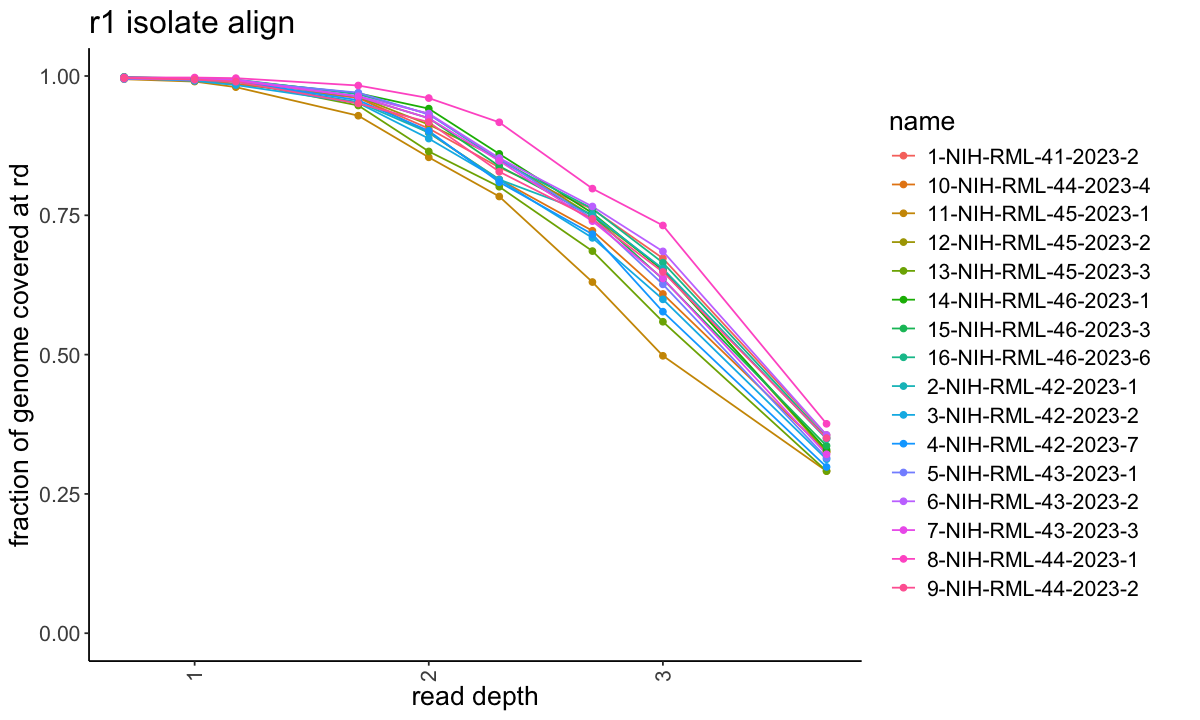

In [11]:
options(repr.plot.width = 10, repr.plot.height = 6)

COV_DF1 %>%
    ggplot(., aes(x=log10(rd_requirement), y=percentage, group = name, color = name)) + 
    geom_line() + 
    geom_point() +
    ylim(0, 1.00) +
    labs(x='read depth', y='fraction of genome covered at rd', title = 'r1 isolate align') 

# Replicate 2 data: 

In [12]:
filt_list = c()
min_filt_list = c()
COV_DF2 = data.frame()

for (f in r2_files){ # filter for con positions first
    t = appendVoc(ay119_aadf, ay119_ntdf, f)
    temp_list = returnConList(t, 'ay119_nt', 5, 0.01)
    temp_minlist = returnMinList(t, ntlist, minor_cov, 0.01)
    filt_list = c(filt_list, temp_list)
    min_filt_list = c(min_filt_list, temp_minlist)
    
    
    COV_DF2 = rbind(COV_DF2, GrabCoverage(t, 5, percent_requirement))
    COV_DF2 = rbind(COV_DF2, GrabCoverage(t, 10, percent_requirement))
    COV_DF2 = rbind(COV_DF2, GrabCoverage(t, 15, percent_requirement))
    COV_DF2 = rbind(COV_DF2, GrabCoverage(t, 50, percent_requirement))
    COV_DF2 = rbind(COV_DF2, GrabCoverage(t, 100, percent_requirement))
    COV_DF2 = rbind(COV_DF2, GrabCoverage(t, 200, percent_requirement))
    COV_DF2 = rbind(COV_DF2, GrabCoverage(t, 500, percent_requirement))
    COV_DF2 = rbind(COV_DF2, GrabCoverage(t, 1000, percent_requirement))
    COV_DF2 = rbind(COV_DF2, GrabCoverage(t, 5000, percent_requirement))
}
filt_list = c(levels(factor(filt_list)))
min_filt_list = c(levels(factor(min_filt_list)))

In [13]:
condf2 = data.frame()
mindf2 = data.frame()
low_cov2 = data.frame()

for (f in r2_files){ # filter for con positions first
    t = appendVoc(ay119_aadf, ay119_ntdf, f)
    
    temp_cov = t %>% filter(totalcount < con_cutoff) %>% select(name, gene_id, ntpos) %>% unique()
    tempdf = grabConsensus(t, filt_list, aminoacids, 'ay119_aa')
    temp_mindf = grabMin(t, min_filt_list)
    
    condf2 = rbind(condf2, tempdf)
    mindf2 = rbind(mindf2, temp_mindf)
    low_cov2 = rbind(low_cov2, temp_cov)
}


In [14]:
condf2_nsps = condf2 %>% filter(!gene_id %in% c('ORF1a', 'ORF1b'))  # removing orf1a and orf1b info - will likely use later on
mindf2_nsps = mindf2 %>% filter(!gene_id %in% c('ORF1a', 'ORF1b'))  # removing orf1a and orf1b info - will likely use later on

condf2_nsps = merge(condf2_nsps, meta, by.x = c('name'), by.y = c('miseq'), all.x = TRUE)
mindf2_nsps = merge(mindf2_nsps, meta, by.x = c('name'), by.y = c('miseq'), all.x = TRUE)

condf2 = condf2 %>% filter(!gene_id %in% nsps)  # will use for now - to filter etc. 
mindf2 = mindf2 %>% filter(!gene_id %in% nsps)  # will use for now - to filter etc. 

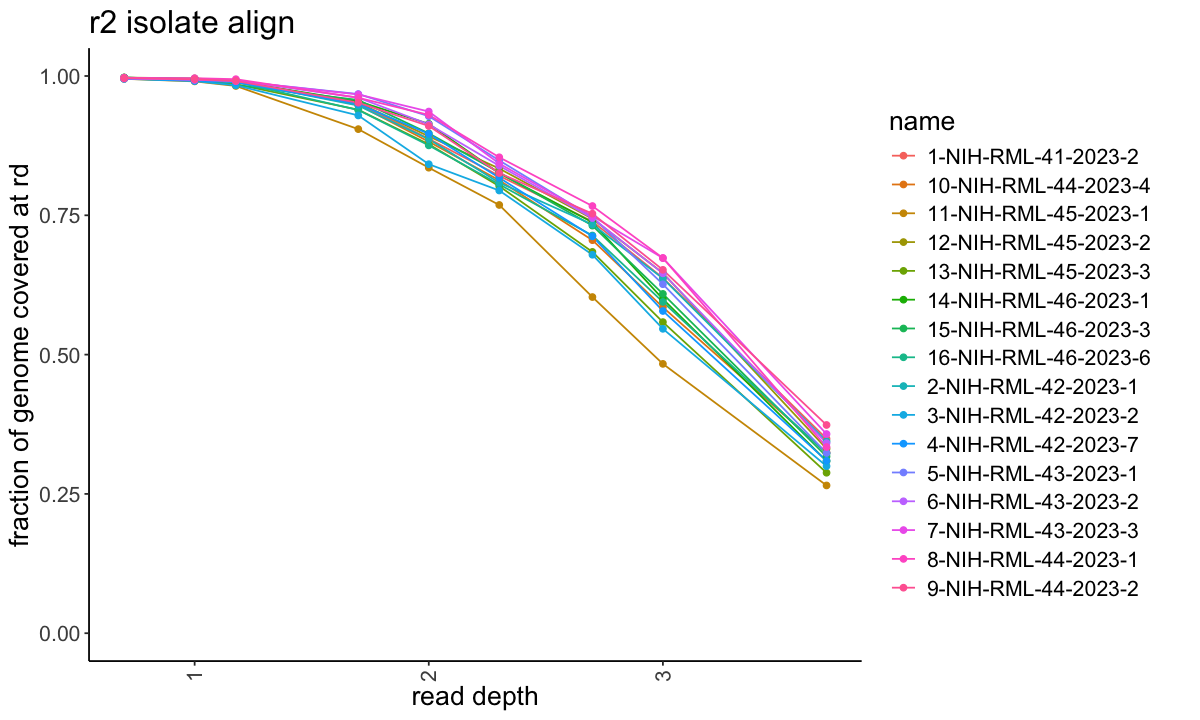

In [15]:
options(repr.plot.width = 10, repr.plot.height = 6)

COV_DF2 %>%
    ggplot(., aes(x=log10(rd_requirement), y=percentage, group = name, color = name)) + 
    geom_line() + 
    geom_point() +
    ylim(0, 1.00) +
    labs(x='read depth', y='fraction of genome covered at rd', title = 'r2 isolate align') 

# Merge the replicate data: 

In [16]:
condf = merge(condf1_nsps %>% select(all_of(select_list)), 
              condf1_nsps %>% select(all_of(select_list)), 
              by = merge_list) %>% 

        mutate(major = ifelse(major.x == major.y, major.x, NA),
               majorfreq = ifelse(major.x == major.y, (majorfreq.x + majorfreq.y)/2, NA),
               totalcount = ifelse(major.x == major.y, (totalcount.x + totalcount.y)/2, NA),
               majoraa = ifelse(majoraa.x == majoraa.y, majoraa.x, NA),
               majorcodon = ifelse(majorcodon.x == majorcodon.y, majorcodon.x, NA)) %>% 
    unique()

In [17]:
condf %>% 
    filter(majoraa != ay119_aa) %>%
    arrange(aapos) %>%
    mutate(variant = glue("{gene_id}: {ay119_aa}{aapos}{majoraa}"), 
          value = 1)  %>%
    select(location,plaque_pick, variant, value) %>%
    unique() %>% 
    pivot_wider(values_from = value, names_from = variant) %>%
    arrange(location, plaque_pick)

location,plaque_pick,ORF6: L4F,S: R19T,ORF8: A55V,N: P142Q,S: E406D,S: V445A,S: G446V,S: L455F,S: S477N,S: K478E,S: Q493K,S: T573I,S: G1267R
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
p45_L_bronchus,1,NA,1,NA,NA,NA,1,NA,NA,1,1,1,NA,NA
p45_L_bronchus,2,NA,1,NA,NA,NA,1,NA,NA,1,1,1,NA,NA
p45_L_bronchus,4,NA,1,NA,NA,NA,1,NA,NA,1,1,1,NA,NA
p45_L_inferior_lobe,1,NA,1,NA,NA,NA,1,NA,NA,1,1,1,NA,NA
p45_L_inferior_lobe,2,NA,1,NA,NA,NA,1,NA,NA,1,1,1,NA,NA
p45_L_inferior_lobe,3,NA,1,NA,NA,NA,1,NA,NA,1,1,1,NA,NA
p45_Sinus_turbinate,2,NA,NA,NA,NA,NA,1,NA,NA,1,NA,1,NA,NA
p45_nasal_placode,1,NA,NA,NA,NA,1,NA,1,1,NA,NA,NA,1,NA
p45_nasal_placode,2,NA,NA,1,NA,1,1,NA,NA,1,NA,1,NA,NA


In [18]:
condf %>% 
    filter(majoraa != ay119_aa & 
     major != ay119_nt) %>%
    arrange(aapos) %>%
    mutate(variant = glue("{gene_id}: {ay119_aa}{aapos}{majoraa}"), 
          value = majorfreq)  %>%
    select(location,plaque_pick, variant, value) %>%
    unique() %>% 
    pivot_wider(values_from = value, names_from = variant) %>%
    arrange(location, plaque_pick)


location,plaque_pick,ORF6: L4F,S: R19T,ORF8: A55V,N: P142Q,S: E406D,S: V445A,S: G446V,S: L455F,S: S477N,S: K478E,S: Q493K,S: T573I,S: G1267R
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
p45_L_bronchus,1,NA,0.9997785,NA,NA,NA,1.0000000,NA,NA,1,1.0000000,0.9285714,NA,NA
p45_L_bronchus,2,NA,0.9995489,NA,NA,NA,1.0000000,NA,NA,1,1.0000000,1.0000000,NA,NA
p45_L_bronchus,4,NA,0.9992406,NA,NA,NA,1.0000000,NA,NA,1,0.9923077,1.0000000,NA,NA
p45_L_inferior_lobe,1,NA,0.9990531,NA,NA,NA,0.9629630,NA,NA,1,1.0000000,1.0000000,NA,NA
p45_L_inferior_lobe,2,NA,0.9991003,NA,NA,NA,1.0000000,NA,NA,1,1.0000000,0.8823529,NA,NA
p45_L_inferior_lobe,3,NA,0.9992355,NA,NA,NA,1.0000000,NA,NA,1,1.0000000,1.0000000,NA,NA
p45_Sinus_turbinate,2,NA,NA,NA,NA,NA,1.0000000,NA,NA,1,NA,1.0000000,NA,NA
p45_nasal_placode,1,NA,NA,NA,NA,1,NA,1,1,NA,NA,NA,1,NA
p45_nasal_placode,2,NA,NA,0.9994343,NA,1,0.9912281,NA,NA,1,NA,1.0000000,NA,NA


In [19]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: aarch64-apple-darwin20.0.0 (64-bit)
Running under: macOS 14.7.2

Matrix products: default
BLAS/LAPACK: /opt/anaconda3/envs/renv1/lib/libopenblas.0.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Biostrings_2.66.0   GenomeInfoDb_1.34.9 XVector_0.38.0     
 [4] IRanges_2.32.0      S4Vectors_0.36.2    BiocGenerics_0.44.0
 [7] stringi_1.8.4       glue_1.7.0          lubridate_1.9.3    
[10] forcats_1.0.0       stringr_1.5.1       dplyr_1.1.4        
[13] purrr_1.0.2         readr_2.1.5         tidyr_1.3.1        
[16] tibble_3.2.1        tidyverse_2.0.0     plyr_1.8.9         
[19] ggplot2_3.5.1      

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-11          tidyselect_1.2.1       repr_1.1.7            
 [4] colorspace_2.1-1       vctrs_0.6.5            generics_0